# What?
In this notebook we will discuss about some topics on model selection in the presence of imabalanced datasets. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## How?
We intend to analyze the behavior (using some classification metrics) of different classification models under various imbalance scenarios
At this point we won't pay too much attention on the optimization of the models themselves. Rather, we will work with the model 'as-is' and compare them with the objective of finding the *best* benchmarking model.

# Imports

In [1]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from typing import Any, List, Dict
from tqdm.auto import tqdm
# from tqdm.notebook import trange, tqdm

# plotting
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation


# sklearn
from sklearn.datasets import make_classification

# Auxiliary Functions

In [2]:
def bootstrap_samples(y_true: List, y_pred: List, n_batches: int = 100) -> List:
    """Get bootstrap samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    preds_samples : array_like, shape = [n_samples, [n_batches, 2]]
        list of bootstrap samples from y_true and y_preds
    """
    # y_true = pd.Series(y_true, name='y_true')
    # y_pred = pd.Series(y_pred, name='y_pred')
    # df_preds = pd.concat((y_true, y_pred), axis=1)
    df_preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    n_samples = len(y_true)
    preds_samples = []
    for i in np.arange(n_batches):

        df_preds_resample = df_preds.sample(n_samples, replace=True)

        y_true_resample = df_preds_resample['y_true'].values
        y_pred_resample = df_preds_resample['y_pred'].values

        preds_samples.append({'y_true': y_true_resample,
                              'y_pred': y_pred_resample})

    preds_samples = preds_samples

    return preds_samples

In [3]:
def delinquency_curve(y_true, y_score, pointwise=True):
    """ Delinquency curve.

    The delinquency curve is curve that shows the default rate in function of
    the approval rate. With this curve is possible to have a clear view of a
    credit operation and its characteristics for all possible scenarios.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        Correct labels for given dataset.

    y_score : array, shape = [n_samples]
        Predict scores for the given dataset.

    pointwise : bool, optional
        boolean indicating whether to compute pointwise delinquency curve.

    Returns
    -------
    approval_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Array containing the approval rates used to compute the default_rate
        curve.
    default_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Default rate values for the approval rates provided in approval_rate.
        default_rate[i] is the ratio of events registered in the best
        approval_rate[i]% of scores.

    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    assert len(y_true) == len(y_score), F"y_true and y_score doesn't have " \
        F"the same length. len(y_true) = " \
        F"{len(y_true)}, len(y_score) = " \
        F"{len(y_score)}"

    indexsort = np.argsort(y_score)[::-1]
    y_approved = y_true[indexsort].copy()

    if pointwise:
        list_index = np.arange(1, len(y_approved)+1)
        approval_rate = np.append(0, list_index/len(list_index))
        default_rate = np.append(0, y_approved.cumsum()/list_index)
    else:
        approval_rate = np.linspace(0, 1, 21)
        n = len(y_true)

        default_rate = np.array([y_approved[:int(np.floor(i * n))].mean()
                                 if (y_approved[:int(np.floor(i * n))]
                                     .size)
                                 else 0 for i in approval_rate])
    return approval_rate, default_rate

In [4]:
def compute_metrics(y_true: List, y_proba: List, n_round: int = 2) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_round : int, optional
        number o decimals to round gini and ks metrics
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = np.round(roc_auc_score(y_true, y_proba), n_round)
    # GINI
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    # Average precision
    metrics['avg_precision'] = np.round(average_precision_score(y_true, y_proba), n_round)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {'fpr': fpr,
                            'tpr': tpr, 
                            'thresholds': thresholds_roc}
    # Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve'] = {'precision' : precision,
                            'recall': recall,
                            'thresholds': thresholds_pr}
    # Delinquency curve
    d_curve_p = delinquency_curve(y_true = y_true, y_score = 1 - y_proba, pointwise= True)
    d_curve_agg = delinquency_curve(y_true = y_true, y_score = 1 - y_true, pointwise = False)
    metrics['d_curve_pointwise'] = d_curve_p
    metrics['d_curve_agg'] = d_curve_agg

    return metrics


In [5]:
def compute_metrics_bootstrap(y_true, y_pred, n_batches=100):
    """computes frequently used metrics from bootstramp samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    metrics_summary : dict
        dictionary containig statistics of gini, ks, d_curve and c_curves
    """
    preds_samples = bootstrap_samples(y_true, y_pred, n_batches)

    df_metrics = pd.DataFrame([compute_metrics(y['y_true'],
                                                     y['y_pred'])
                              for y in preds_samples])

    approval_rate_p = df_metrics['d_curve_pointwise'].iloc[0][0]
    default_rate_mean_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).mean()
    default_rate_std_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_p = (approval_rate_p, default_rate_mean_p)
    d_curve_std_p = (approval_rate_p, default_rate_std_p)

    approval_rate_agg = df_metrics['d_curve_agg'].iloc[0][0]
    default_rate_mean_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).mean()
    default_rate_std_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_agg = (approval_rate_agg, default_rate_mean_agg)
    d_curve_std_agg = (approval_rate_agg, default_rate_std_agg)

    metrics_stats = df_metrics[['roc_auc',
                                'gini',
                                'avg_precision',
                                # 'ks'
                                ]].apply([np.mean, np.std])

    metrics_summary = {'d_curve_pointwise': {'d_curve_mean': d_curve_mean_p,
                                             'd_curve_std': d_curve_std_p},
                       'd_curve_agg': {'d_curve_mean': d_curve_mean_agg,
                                       'd_curve_std': d_curve_std_agg},
                       'metrics_stats': metrics_stats,
                       'df_metrics': df_metrics}
    return metrics_summary

In [6]:
def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

# Data
We will write a function that generates synthetic binary classification data allowing for various class imbalance levels

In [7]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

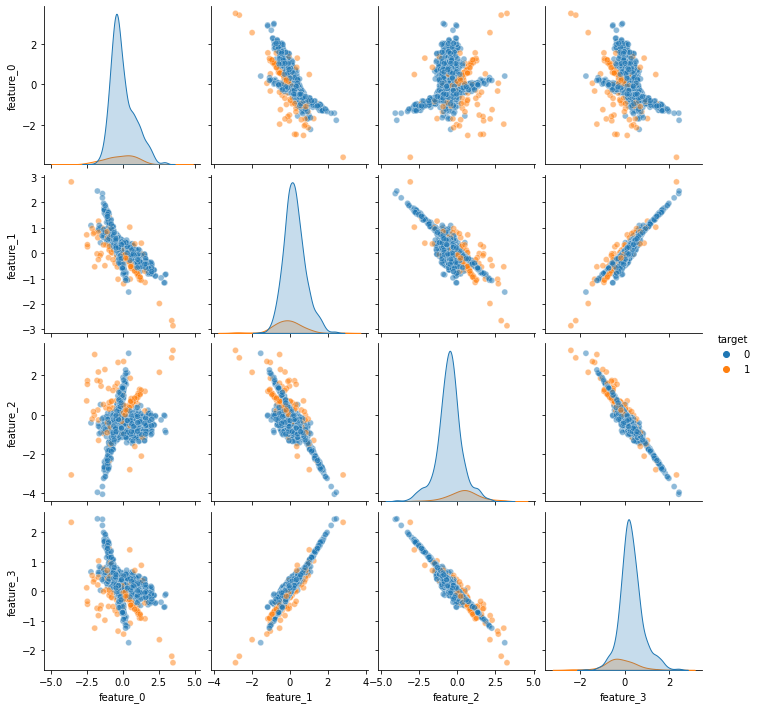

In [8]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})


# Model comparison
In this section we will compare the performance (and other aspects) of different models under different class imbalance scenarios.
We will start by analyzing the performance dependence on the class imbalance index which we define as being the minority class ratio or *Prevalence*. If we call $N_{P}$ and $N_{N}$ the number of positive and negative observations, the prevalance is given by:
$$\nu := \dfrac{N_{P}}{N_{P}+N_{N}}.$$
The main parameter to be explored is $\nu$, going from an equal-class setup to a highly imbalanced scenario where there really few examples of the minority class.

The first simple analysis is to be made upon the performance impact of the imbalance in classes for several algorithms. At this point we are interested in answering a simple practical question:

In order to center text in md files you can use the center tag like html tag:

<center><span style="background-color: blue">What is the best benchmark algorithm in the presence of class imbalance?</span></center>


To answer this question we might be interested in looking at other aspects of the statistical learning process aside of the classification performance metrics, such as: 
* Sample Size
* Fit Time
* Model complexity

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve,\
                            average_precision_score, f1_score, auc


## Performance Impact
Let us see how the performance changes for different imbalance ratios:

In [10]:
n_samples = 10**5
n_features = 4
n_informative = 2
class_sep = 0.5
metrics = {}
fit_time = {}
imbalances = [0.5, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-3, 5e-4]
random_state = 420
for imbalance in tqdm(imbalances):
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    # Train test split
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression
    print('\tLog Regression ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    # metrics[imbalance]['logreg'] = compute_metrics(y_true = y_test, y_proba = y_proba_lr[:,1])
    metrics[imbalance]['logreg'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Decision Tree
    print('\tDecision Tree ...')
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    y_proba_dt = dt_clf.predict_proba(X_test)
    # metrics[imbalance]['dt'] = compute_metrics(y_true = y_test, y_proba= y_proba_dt[:,1])
    metrics[imbalance]['dt'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dt[:,1])

    # Random Forest
    print('\tRandom Forest ...')
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Naive Bayes
    print('\tNaive Bayes ...')
    nb_clf = GaussianNB()
    nb_clf.fit(X_train, y_train)
    y_proba_nb = nb_clf.predict_proba(X_test)
    metrics[imbalance]['nb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_nb[:,1])

    # Gradient Boosting Machine
    print('\tGradient Boosting ...')
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Dummy Classifier
    print('\tDummy Classifier ...')
    dummy_clf = DummyClassifier()
    dummy_clf.fit(X_train, y_train)
    y_proba_dummy = dummy_clf.predict_proba(X_test)
    metrics[imbalance]['dummy'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dummy[:,1])

    # # SVM Classifier
    # print('Support Vector Machine ...')
    # svm_pipeline = Pipeline([('scaler', StandardScaler()),
    #                         ('svc', SVC(gamma = 'auto',
    #                                     probability= True))])
    # svm_pipeline.fit(X_train, y_train)
    # y_proba_svm = svm_pipeline.predict_proba(X_test)
    # metrics[imbalance]['svm'] = compute_metrics_bootstrap(y_true= y_test, y_pred = y_proba_svm[:,1])

print('end')

  0%|          | 0/8 [00:00<?, ?it/s]

Minority class proportion: 0.5
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 12%|█▎        | 1/8 [00:35<04:06, 35.17s/it]

Minority class proportion: 0.2
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 25%|██▌       | 2/8 [01:10<03:30, 35.00s/it]

Minority class proportion: 0.1
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 38%|███▊      | 3/8 [01:44<02:54, 34.91s/it]

Minority class proportion: 0.05
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 50%|█████     | 4/8 [02:20<02:21, 35.27s/it]

Minority class proportion: 0.01
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 62%|██████▎   | 5/8 [02:55<01:45, 35.12s/it]

Minority class proportion: 0.005
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 75%|███████▌  | 6/8 [03:29<01:09, 34.76s/it]

Minority class proportion: 0.001
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


 88%|████████▊ | 7/8 [04:02<00:34, 34.28s/it]

Minority class proportion: 0.0005
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...


100%|██████████| 8/8 [04:33<00:00, 34.15s/it]

end


In [11]:
def plot_metric_evolution(metrics: Dict, 
                          model_name: str,
                          metric_4_display: str = 'roc_auc',
                          color: str = 'purple', 
                          ax: matplotlib.axis = None) -> matplotlib.axis:
    """
    Plots the imbalance-evolution of classification metrics

    """
    labels = {'logreg': 'Logistic Regression',
              'dt': 'Decision Tree',
              'rf': 'Random Forest',
              'nb': 'Naive Bayes',
              'gb': 'Gradient Boosting',
              'dummy': 'Dummy Classifier' }
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    metrics_mean = [metrics[x][model_name]['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
    metrics_std = [metrics[x][model_name]['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
    x = range(len(metrics.keys()))
    ax.plot(metrics_mean, marker = '.', linestyle = '--',
            color = color, label = labels[model_name],
            alpha = 0.6)
    ax.fill_between(x = x, 
                    y1 = np.subtract(metrics_mean, metrics_std), 
                    y2 =np.add(metrics_mean, metrics_std),
                    alpha = 0.3, facecolor = color)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.set_xlabel('Minority class proportion')
    return ax

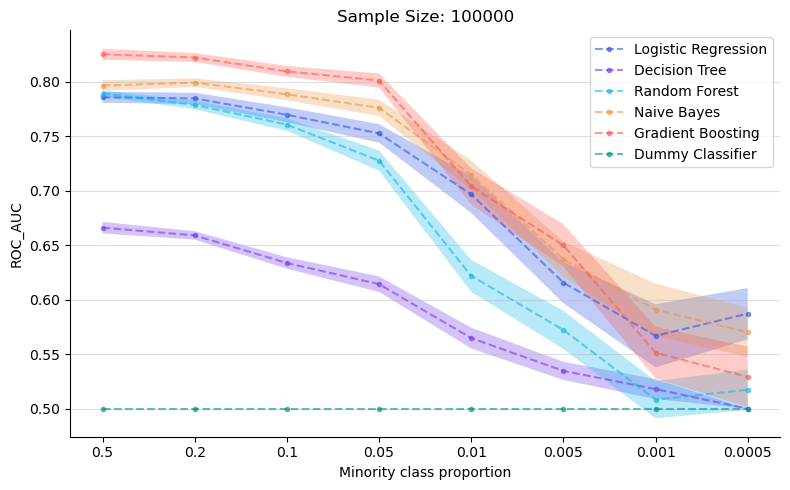

In [12]:
metric_4_display = 'roc_auc'
colors = {'logreg': '#2F58EB',
          'dt': '#773BEB',
          'rf': '#12B8EB',
          'nb': '#EB9846',
          'gb': '#FC5A50',
          'dummy': '#029386'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best')
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Sample Size: {n_samples}')
clean_ax(ax)
f.tight_layout()

Let us plot the evolution of ROC and PR curves. We will first fix the imbalance ratio and plot the curves for all models under comparison. 
Since the metrics were computed for bootstrapped samples of predictions we will actually plot the mean ROC and PR curves. The computation of these mean curves must be taken with care since an intermediate interpolation step is carried out for the mean curve calculation. In particular, the interpolation between two points in PR space might not be linear, see section 4 in [The Relationship between Precision-Recall and ROC curves](https://www.biostat.wisc.edu/~page/rocpr.pdf). This interpolation procedure will be revisited in the near future.

Then we can vary the imbalance ratio $\nu$ to see the evolution of the ROC and PR curves.


In [13]:
def plot_roc_curve(df_metrics: pd.DataFrame,
                    color: str = 'purple',
                    label : str = None, 
                    ax : matplotlib.axis = None) -> matplotlib.axis:
    """plots the roc curve for a bootstrapped confidence interval
    Parameters
    ----------
    df_metrics: pd.DataFrame
        dataframe that holds the roc curves for each boostrap sample
    label: str, (default = None)
    axis: matplotlib.axis (default = None)
    Returns
    -------
    ax: matplotlib.axis
    """
    assert isinstance(df_metrics, pd.DataFrame), 'df_metrics has to be a dataframe object!'
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    if label == None:
        label = 'mean ROC curve'
    # Define the mean false positive rate
    mean_fpr = np.linspace(0, 1, 100)
    # Interpolate the roc curves using the mean fpr values
    tprs = []
    for i in range(df_metrics.shape[0]):
        tpr = df_metrics['roc_curve'][i]['tpr']
        fpr = df_metrics['roc_curve'][i]['fpr']
        inter_tpr = np.interp(mean_fpr, fpr, tpr)
        inter_tpr[0] = 0.0
        tprs.append(inter_tpr)
        del inter_tpr
    mean_tpr = np.mean(tprs, axis = 0)
    std_tpr = np.std(tprs, axis = 0)
    ax.plot(mean_fpr, mean_tpr, 
        color = color, 
        label = label,
        linestyle = '--',
        alpha = 0.8)
    ax.fill_between(mean_fpr, 
                y1 = mean_tpr - std_tpr,
                y2 = mean_tpr + std_tpr,
                alpha = 0.12, facecolor = color)
    ax.legend(loc = 'best', frameon = False)
    return ax
    

In [14]:

def plot_pr_curve(df_metrics: pd.DataFrame,
                    color: str = 'purple',
                    label : str = None, 
                    ax : matplotlib.axis = None) -> matplotlib.axis:
    """plots the precisio-recall curve for a bootstrapped PR calculation
    Parameters
    ----------
    df_metrics: pd.DataFrame
        dataframe that holds the pr curves for each boostrapped sample
    label: str, (default = None)
    axis: matplotlib.axis (default = None)
    Returns
    -------
    ax: matplotlib.axis
    """
    assert isinstance(df_metrics, pd.DataFrame), 'df_metrics has to be a dataframe object!'
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    if label == None:
        label = 'mean PR curve'
    # Define the mean recall
    mean_recall = np.linspace(0, 1, 100)
    precisions = []
    aucs = []
    # Interpolate the precision curves
    for i in range(df_metrics.shape[0]):
        precision = df_metrics['pr_curve'].iloc[i]['precision']
        recall = df_metrics['pr_curve'].iloc[i]['recall']
        interp_precision = np.interp(x = mean_recall, xp = recall[::-1], fp = precision[::-1])
        precisions.append(interp_precision)
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
    mean_precision = np.mean(precisions, axis = 0)
    std_precision = np.std(precisions, axis = 0)
    # Actual Plot
    ax.plot(mean_recall, mean_precision,
            color = color,
            label = label,
            linestyle = '--',
            alpha = 0.8)
    ax.fill_between(mean_recall, 
                    y1 = mean_precision - std_precision,
                    y2 = mean_precision + std_precision,
                    alpha = 0.12, facecolor = color)
    ax.legend(loc = 'best', frameon = False)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    return ax

In [15]:
colors

{'logreg': '#2F58EB',
 'dt': '#773BEB',
 'rf': '#12B8EB',
 'nb': '#EB9846',
 'gb': '#FC5A50',
 'dummy': '#029386'}

Text(0.5, 0.98, 'LOGREG')

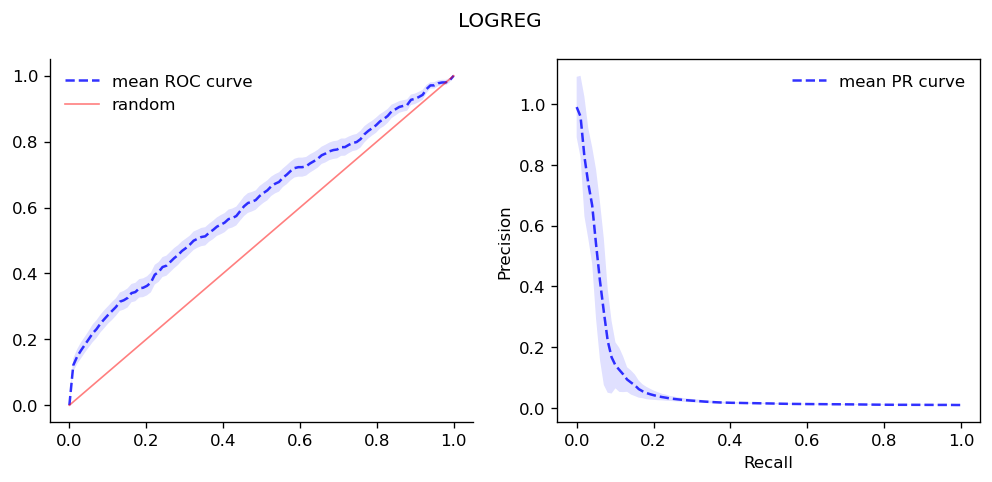

In [16]:
imbalance = 0.005
model_name = 'logreg'
# Get metrics
df_metrics = metrics[imbalance][model_name]['df_metrics']
# Plot
f, ax = plt.subplots(1,2, dpi = 120, figsize = (10,4))
plot_roc_curve(df_metrics, color = 'blue',
                ax = ax[0])
ax[0].plot([0,1],[0,1], lw = 1,
            color = 'r', 
            label = 'random',
             alpha = 0.5)
ax[0].legend(frameon = False)
plot_pr_curve(df_metrics=df_metrics, color = 'blue', ax = ax[1])
clean_ax(ax[0])
f.suptitle(model_name.upper())

In [17]:
from matplotlib import cm

cmap = cm.get_cmap('winter')
color_dict = {imbalances[i]: cmap(1- i/len(imbalances)) for i in np.arange(len(imbalances))}


MovieWriter imagegick unavailable; using Pillow instead.


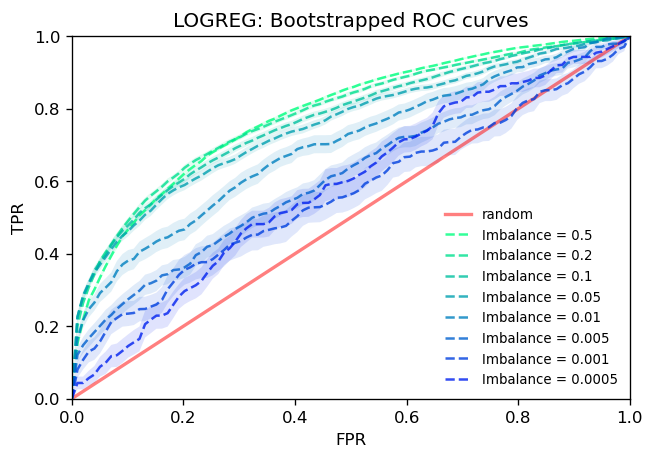

In [18]:
model_name = 'logreg'

fig = plt.figure(dpi = 120)
plt.xlim((0, 1)) 
plt.ylim((0, 1))
line, = plt.plot([0,1],[0,1], 
                color = 'r', 
                lw = 2, 
                alpha = 0.5,
                label = 'random')
def init():
    """plot initialization function"""
    line.set_data([0,1],[0,1])
    return line, 
def animate(i):
    """plot animation function"""
    imbalance = imbalances[i]
    # Get metrics
    df_metrics = metrics[imbalance][model_name]['df_metrics']
    # Define the mean false positive rate
    mean_fpr = np.linspace(0, 1, 100)
    # Interpolate the roc curves using the mean fpr values
    tprs = []
    for i in range(df_metrics.shape[0]):
        tpr = df_metrics['roc_curve'][i]['tpr']
        fpr = df_metrics['roc_curve'][i]['fpr']
        inter_tpr = np.interp(mean_fpr, fpr, tpr)
        inter_tpr[0] = 0.0
        tprs.append(inter_tpr)
        del inter_tpr
    mean_tpr = np.mean(tprs, axis = 0)
    std_tpr = np.std(tprs, axis = 0)
    plt.plot(mean_fpr, mean_tpr, 
        color = color_dict[imbalance], 
        label = f'Imbalance = {imbalance}',
        linestyle = '--',
        alpha = 0.8)
    plt.fill_between(mean_fpr, 
                y1 = mean_tpr - std_tpr,
                y2 = mean_tpr + std_tpr,
                alpha = 0.12, facecolor = color_dict[imbalance])
    plt.legend(loc = 'best', frameon = False, fontsize = 8)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'{model_name.upper()}: Bootstrapped ROC curves')
anim = FuncAnimation(fig, animate, init_func= init, frames = len(imbalances), interval = 10**5)
anim.save(f'{model_name}_ROC_animation.gif', writer = 'imagegick', fps=1.5, dpi = 120)
plt.show()


## Next steps 
* keep training set imbalance fixed while changing the imbalance in the test set
* construct a big dataset and sample imbalanced datasets such that we alwasy have the same number of positive samples. So, the imbalance ratio depends only in the 

Now that we know how to plot the ROC and PR curves

## Sample Size effect

At first sight the Logistic Regression performance dependence on imbalance is very similar to the Gradient Boosting Machine, which makes the Logisitic Regression a good candidate for a benchmark model. What other quantities should we look at? 
* Training time
* model complexity

# Model Assessment and Selection `v0`

In this section we will discuss the problem of model selection inside the imbalanced learning context. To begin the discussion let us introduce some general definitions of the binary classification problem.
In general terms, we are interested in extracting information about an **unknown** joint probability distribution $\text{Pr}(X,Y)$ of random variables $X, Y$ from which we got a sample $\mathcal{D} = \{(x_i, y_i)\}_{i = 1, \dots, n}$ (the dataset), with the random variable $Y$ taking values in $\{0,1\}$. 
The binary classification problem can be summarized as the problem of finding a function $f: X \longrightarrow \{0,1\}$ defined by:
$$f(x):= \mathbb{P}(Y=1 | X=x),$$
often called **score**. In practice, solving the classification problem implies using an **estimator** function $\hat{f}:X \longrightarrow [0,1]$. It is worth mentioning that the output of this estimator function is not to be interpreted as a probability, in general. A more detailed discussion will be given in the model calibration section.
The classification problem is not entirely solved by finding the best estimator function $\hat{f}$ since in general we could be actually interested in predicting the class to which a particular example belongs, this is, we are looking for an estimator:
$$\hat{y}_{\lambda}(x) = \begin{cases}
                1,\;\; \text{if } \hat{f}(x) \geq \lambda, \\ 
                0, \;\; \text{if } \hat{f}(x) < \lambda
            \end{cases}$$
In this terms, we can state the problem of **model selection** as trying to answer the following question:
> Given a set of estimators $\{\hat{f}_1, \hat{f}_2, \dots\}$, *what is the best estimator function* $\hat{f}: X \longrightarrow [0,1]$ among them?*

What does it mean to be *the best* estimator anyway? We will begin the model selection discussion by trying to answer this question. 
Note that there is a related question that we will try to solve (at the same time) related to the choice of the $\lambda$ threshold parameter.

There are different criteria by which several **estimators** are compared. In practice, however, we are mainly interested in measuring:
* missclassification error or classification metrics
* model complexity and *bias-variance* tradeoff
* training time
* sensitivity to class imbalance
* ...
  
Often, solving a binary classification problem involves optimizing the hyperparameters of inference models. This process can be both computationally intensive and time consuming. Thus, the gain in performance obtained by following this optimization procedure has to justify the effort, otherwise we would choose to go on with a simpler model. To this end, it is common to compare the resulting complex model with a most simple and interpretable model (usually logistic regression).

## Error estimation
There are different measures of missclassification error and choosing one, in general, depends on the business problem and the characteristics of the joint probability distribution $\text{Pr}(X,Y)$ that we can access through a sample.
Consider a prediction model $\hat{f}: X \longrightarrow [0,1]$ whose paremeters were estimated using a training set $\mathcal{T}$. Consider also an error (loss) function $L: \{0,1\} \times [0,1] \longrightarrow \mathbb{R}_{+}$, such that the missclassification error of a predicted observation $\hat{y} = \hat{f}(x)$, where $x \sim X$ is denoted $L(y, \hat{y})$. One example of such a function and a common choice for binary classification problems is the so called **Binary Cross-Entropy** or **Log Loss**, given by:
\begin{align*}
L = -\dfrac{1}{N}\sum_{i = 1}^{N}\left[y_i \log(\hat{y}_i)+ (1 - y_i)\log(1 - \hat{y}_i)\right]
\end{align*}
where $N$ is the size of the sample $\mathcal{D}$ used for the error estimation, $y_i$ is the $i$-th ground truth value an $\hat{y}_i$ is the $i$-th estimated value (with estimator $\hat{f}$).
The **Test error** or **Generalization error** is the missclassification error calculated on an independent data sample, commonly called *test set*.
\begin{align}
\text{Err}_{\mathcal{T}} = \mathbb{E}\left[L(Y, \hat{f}(X))| \mathcal{T}\right],
\end{align}
note that the training set is fixed. We can also average over the training set generation process to get the *expected prediction error*:
\begin{align}
\text{Err} = \mathbb{E}\left[L(Y, \hat{f}(X))\right] = \mathbb{E}\left[\text{Err}_{\mathcal{T}}\right].
\end{align}
**Training error** (resubstitution error) is nothing else that the missclassification error calculated on the training dataset $\mathcal{T}$. As the following analysis will show, the training error is not a good estimate of the true error.


### Coding interlude
In order to illustrate how the training error is not a good estimate of the test error let us consider the loss dependance on the model complexity. Consider then, the case of a binary classificatition problem that we are trying to solve using a **logistic regression** or another more complex model (such as GBDT). We will analyze the behavior of the error estimates for different realizations of the test set $\mathcal{T}$. To do that, let us construct a big dataset (parent distribution) from which we will sample different realizations of the training set. Aditionally, a hold-out dataset (the test dataset) will be sampled a single time from the parent distribution.

In [19]:
from sklearn.metrics import log_loss

In [20]:
n_samples = 10**4
random_state = 42
n_features = 10
data, col_names = create_imbalanced_binary_classification(n_samples = n_samples, n_features = n_features, 
                                                            n_informative = int(n_features/2), imbalance = 0.3,
                                                            random_state = random_state, class_sep = 0.5)
data.target.mean()

0.3018

In [21]:
X = data[col_names]
y = data['target']
X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
train_sample_size = 0.4
n_trials = 100
max_depths = [2, 3, 5, 8, 15, 30, 50]
results_train = {key: {i: None for i in range(n_trials)} for key in max_depths}
results_test = {key: {i: None for i in range(n_trials)} for key in max_depths}
for n, i in tqdm(product(max_depths, range(n_trials))):
    idx = X_train_0.sample(frac = train_sample_size).index
    X_train = X_train_0.loc[idx]
    y_train = y_train_0.loc[idx]
    # Decision Tree
    # print(f'\tDecision Tree | max_depth = {n}')
    dt_clf = DecisionTreeClassifier(max_depth = n)
    dt_clf.fit(X_train, y_train)
    y_proba = dt_clf.predict_proba(X_test)
    y_proba_train = dt_clf.predict_proba(X_train)
    results_train[n][i] = log_loss(y_train, y_proba_train) 
    results_test[n][i] = log_loss(y_test, y_proba) 

700it [00:18, 38.64it/s]


In [22]:
results_stats_train = pd.DataFrame({key : {'mean': np.mean(list(results_train[key].values())),
                        'std': np.std(list(results_train[key].values()))} for key in max_depths})
results_stats_test = pd.DataFrame({key : {'mean': np.mean(list(results_test[key].values())),
                        'std': np.std(list(results_test[key].values()))} for key in max_depths})

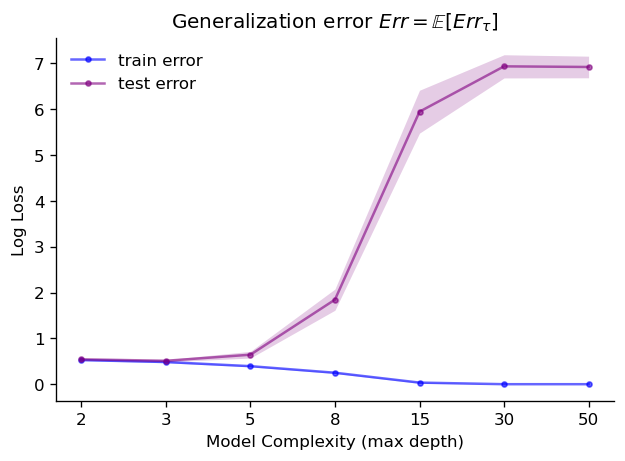

In [23]:
f, ax = plt.subplots(dpi = 120)
x = np.arange(len(max_depths))
ax.plot(x, results_stats_train.loc['mean', :].values,
            marker = '.',
            label = 'train error',
            color = 'b',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_train.loc['mean', :].values - results_stats_train.loc['std', :].values,
                y2 = results_stats_train.loc['mean', :].values + results_stats_train.loc['std', :].values,
            color = 'b', alpha = 0.2, linewidth=0)

ax.plot(x, results_stats_test.loc['mean', :].values,
            marker = '.',
            label = 'test error',
            color = 'purple',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_test.loc['mean', :].values - results_stats_test.loc['std', :].values,
                y2 = results_stats_test.loc['mean', :].values + results_stats_test.loc['std', :].values,
            color = 'purple', alpha = 0.2, linewidth=0)
ax.set_xticks(x)
ax.set_xticklabels(max_depths)
ax.set_xlabel('Model Complexity (max depth)')
ax.set_ylabel('Log Loss')
ax.legend(loc = 'best', frameon = False)
ax.set_title(r'Generalization error $Err = \mathbb{E}[Err_{\tau}]$')
clean_ax(ax)
plt.show()

Let us see another example where we use an ensemble of decision trees, such as Gradient Boosted Decision Trees. We are interested in the training-test error gap as the number of weak learners increases. 

In [24]:
from lightgbm import LGBMClassifier

MovieWriter imagegick unavailable; using Pillow instead.


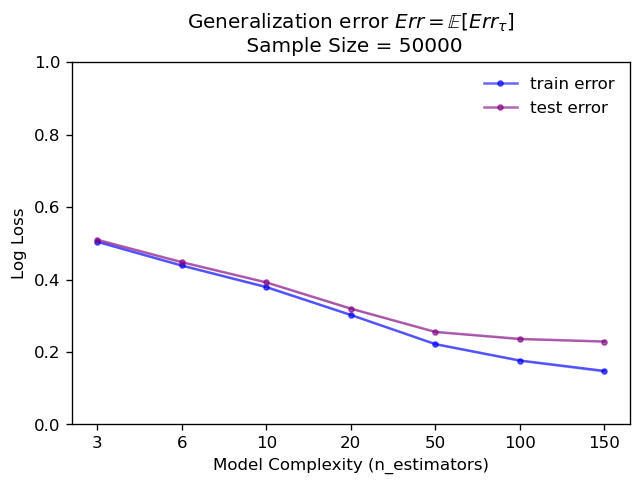

In [25]:
# animation parameter
n_samples_list = [100, 500, 10**3, 5*10**3, 10**4, 5*10**4] 

fig = plt.figure(dpi = 120)
line, = plt.plot([],[])
def init():
    """plot initialization function"""
    line.set_data([],[])
    return line, 
def animate(i):
    """Animates the training vs true error estimatives for different sample sizes and fixed imbalance"""
    fig.clear()
    # n_samples_list = [100, 500, 10**3, 10**4, 10**5]
    n_samples = n_samples_list[i]
    random_state = 42
    n_features = 10
    data, col_names = create_imbalanced_binary_classification(n_samples = n_samples, n_features = n_features, 
                                                            n_informative = int(n_features/2), imbalance = 0.3,
                                                            random_state = random_state, class_sep = 0.5)
    parent_positive_rate = data.target.mean()
    X = data[col_names]
    y = data['target']
    X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
    train_sample_size = 0.5
    n_trials = 10
    n_estimators = [3, 6, 10, 20, 50, 100, 150]
    results_train = {key: {i: None for i in range(n_trials)} for key in n_estimators}
    results_test = {key: {i: None for i in range(n_trials)} for key in n_estimators}
    for n, i in product(n_estimators, range(n_trials)):
        idx = X_train_0.sample(frac = train_sample_size).index
        X_train = X_train_0.loc[idx]
        y_train = y_train_0.loc[idx]
        # Model training
        clf = LGBMClassifier(n_estimators = n)
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
        y_proba_train = clf.predict_proba(X_train)
        results_train[n][i] = log_loss(y_train, y_proba_train) 
        results_test[n][i] = log_loss(y_test, y_proba)
    # Get results for plotting
    results_stats_train = pd.DataFrame({key : {'mean': np.mean(list(results_train[key].values())),
                        'std': np.std(list(results_train[key].values()))} for key in n_estimators})
    results_stats_test = pd.DataFrame({key : {'mean': np.mean(list(results_test[key].values())),    
                        'std': np.std(list(results_test[key].values()))} for key in n_estimators})
    # Plot the curves
    x = np.arange(len(n_estimators))
    # plt.xlim((0, 1)) 
    plt.ylim((0, 1))
    plt.plot(x, results_stats_train.loc['mean', :].values,
                marker = '.',
                label = 'train error',
                color = 'b',
                alpha = 0.6)
    plt.fill_between(x, 
                    y1 = results_stats_train.loc['mean', :].values - results_stats_train.loc['std', :].values,
                    y2 = results_stats_train.loc['mean', :].values + results_stats_train.loc['std', :].values,
                color = 'b', alpha = 0.2, linewidth=0)

    plt.plot(x, results_stats_test.loc['mean', :].values,
                    marker = '.',
                    label = 'test error',
                    color = 'purple',
                    alpha = 0.6)
    plt.fill_between(x, 
                        y1 = results_stats_test.loc['mean', :].values - results_stats_test.loc['std', :].values,
                        y2 = results_stats_test.loc['mean', :].values + results_stats_test.loc['std', :].values,
                    color = 'purple', alpha = 0.2, linewidth=0)
    plt.xticks(x, n_estimators)
    plt.legend(loc = 'best', frameon = False)
    plt.xlabel('Model Complexity (n_estimators)')
    plt.ylabel('Log Loss')
    plt.title(r'Generalization error $Err = \mathbb{E}[Err_{\tau}]$' + f'\n Sample Size = {n_samples}')
# Fun time!

anim = FuncAnimation(fig, animate, init_func= init, frames = len(n_samples_list), interval = 10**5)
anim.save(f'LGBM_error_animation.gif', writer = 'imagegick', fps=1, dpi = 120)
plt.show()


The above figure (see the animation) shows that the training error severely understimates the test (true) error value as the model becomes more complex, commonly known as *overfitting*. The effect is diminished as the training dataset size grows. The usual method to turnaround this error underestimation problem is known as **Cross-Validation** (CV). In k-fold CV the training dataset $\mathcal{T}$ is split into k mutually-exclusive similar subsets $\{\mathcal{T}_1,\mathcal{T}_2, \dots, \mathcal{T}_k\}$. At each CV round, a different fold is left out of the training procedure and used as a testing set. The error (loss) is then averaged across all folds to obtain the conditional error estimate $\text{Err}_{\mathcal{T}}$. Let $\mathcal{T}_i$ be the left-out test set at the $i$-th fold. Then we can write the estimated conditional missclassification error as:
\begin{align*}
\text{Err}_{\text{CV}} = \dfrac{1}{k}\sum_{i = 1}^{k} L(Y_{\mathcal{T}_i}, \hat{f}(X_{\mathcal{T}_i}))
\end{align*}

The cross validation estimate is a random number that depends on the division into the k-folds. The extreme case where $k = n$ is known as **leave-one-out** cross validation, since a single entity is left out of the training set for each fold. This turns the method more computationally costly as the size of the training dataset grows. The choice for the number of splits is discussed in [kohavi](http://ai.stanford.edu/~ronnyk/accEst.pdf), stratified ten-fold cross-validation being the most common recommendation. 

In the following experiment we will try to estimate the true error [<sup id="fn1">1</sup>](#fn1) using the cross validation strategy. 


[<sup id="fn1">1</sup>](#fn1) Computed on a held-out validation sample that is never seen in the training procedure.

In [26]:
# Generate classification dataset
n_samples = 10**4
random_state = 42
n_features = 10
data, col_names = create_imbalanced_binary_classification(n_samples = n_samples, n_features = n_features, 
                                                            n_informative = int(n_features/2), imbalance = 0.3,
                                                            random_state = random_state, class_sep = 0.5)
data.target.mean()

0.3018

In [27]:
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, RepeatedStratifiedKFold

In [28]:
models = {
    'logreg': Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())
                        ]),
    'random_forest': RandomForestClassifier(),
    'lgbm': LGBMClassifier(n_estimators = 7),
    'gaussian_nb': GaussianNB()
    
}

In [33]:
def run_cross_validation_from_split(model, kfold, X_dev, y_dev, X_valid, y_valid):
    """
    trains and evaluates a model given the kfold generator
    """
    # results storage:
    try:
        n_splits = kfold.n_splits
    except Exception as e:
        print(e)
        n_splits = kfold.get_n_splits()
    results_cv = {f'{i+1}': {
                            'test': None,
                            'valid': None
                            } 
                    for i in range(n_splits)
                }
    for i, (train_index, test_index) in enumerate(kfold.split(X_dev, y_dev)):
        X_train, X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
        y_train, y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]
        ### model training and evaluation
        model.fit(X_train,y_train)
        y_proba = model.predict_proba(X_test)
        y_proba_valid = model.predict_proba(X_valid)
        results_cv[f'{i+1}']['test'] = log_loss(y_test, y_proba)
        results_cv[f'{i+1}']['valid'] = log_loss(y_valid, y_proba_valid)
    return results_cv

10-fold Cross Validation

In [34]:
model_name = 'lgbm'
n_folds = 10
X = data[col_names]
y = data['target']
# Sample validation test set 
X_dev, X_valid, y_dev, y_valid = train_test_split(X, y, test_size = 0.3)
# KFold cross validation
skf = StratifiedKFold(n_folds)
results_cv = run_cross_validation_from_split(model = models[model_name], 
                                                kfold = skf,
                                                X_dev = X_dev,
                                                y_dev = y_dev, 
                                                X_valid = X_valid, 
                                                y_valid = y_valid)

Repeated Cross Validation

In [35]:
rskf = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = 10)
results_repeated_cv = run_cross_validation_from_split(models[model_name], kfold = rskf, 
                                                        X_dev = X_dev, y_dev = y_dev,
                                                        X_valid = X_valid, y_valid = y_valid)

'RepeatedStratifiedKFold' object has no attribute 'n_splits'


Gather all results and plot:

In [78]:
df_results_cv = pd.DataFrame(results_cv).T
df_results_repeated_cv  = pd.DataFrame(results_repeated_cv).T
# For the repeated cross validation results, we need to average over each repetition
df_results_repeated_cv['rep'] = df_results_repeated_cv.reset_index()['index'].astype(int).apply(lambda x: int((x-1)/10)).values
df_results_rep_summarized = df_results_repeated_cv.groupby('rep').mean()

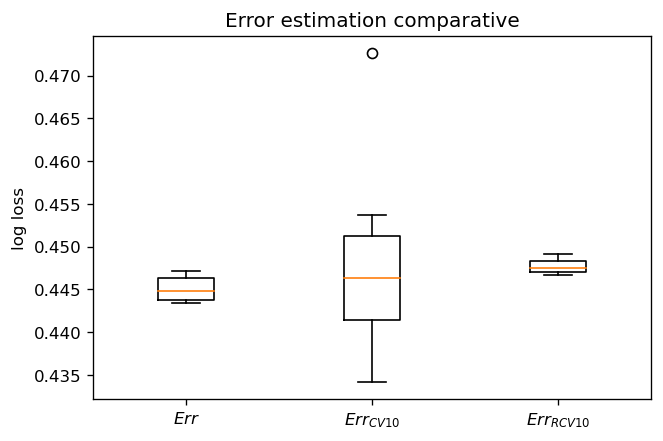

In [81]:
errors = [df_results_cv['valid'].values,\
         df_results_cv['test'].values,\
         df_results_rep_summarized['test']]
x_labels = [r'$Err$',\
            r'$Err_{CV10}$',\
            r'$Err_{RCV10}$']
f, ax =plt.subplots(dpi = 120)
ax.boxplot(errors)
ax.set_xticklabels(x_labels)
ax.set_ylabel('log loss')
ax.set_title('Error estimation comparative')
plt.show()


**Bootstrapped error estimation**: We need to implement a splitter that bootstraps the training samples only. Specifically, we want to implement a k-fold validation such that, at each fold split the trainin sample is bootstraped a certain number of times and a model is trained on each bootstraped sample. This Kfold object could be called `StratifiedBootstrapKFold`

In [84]:
from sklearn.model_selection._split import _BaseKFold

class StratifiedBootstrapKFold(_BaseKFold):
    """Stratified Bootstrap Kfolds cross-validator.

    Provides train/test indices to split date in train/test sets.

    This cross-validation object is a variation of KFold that returns 
    bootstrapped stratified folds. The folds are made by preserving 
    the percentage of samples for each class.

    Parameters
    ----------
    n_splits
    
    """